# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 26/02/2024

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import glob, pprint
import numpy as np
import h5py
from tqdm.notebook import tqdm

import matplotlib
%matplotlib ipympl
from matplotlib import pyplot as plt

import ImageD11.nbGui.nb_utils as utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset

from ImageD11.blobcorrector import eiger_spatial

In [3]:
# define our functions

cmp = {'compression':'gzip',
       'compression_opts': 2,
       'shuffle' : True }

def save_array(grp, name, ary):
    hds = grp.require_dataset(name, 
                              shape=ary.shape,
                              dtype=ary.dtype,
                              **cmp)
    hds[:] = ary
    return hds

def save_grains(grains, ds):
    with h5py.File(ds.grainsfile, 'w') as hout:
        grn = hout.create_group('grains')
        for g in tqdm(grains):
            gg = grn.create_group(str(g.gid))
            save_array(gg, 'peaks_4d_indexing', g.peaks_4d).attrs['description'] = "Strong 4D peaks that were assigned to this grain during indexing"
            gg.attrs.update({'ubi':g.ubi})

In [4]:
# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA

### USER: specify your experimental directory

rawdata_path = "/home/esrf/james1997a/Data/ihma439/id11/20231211/RAW_DATA"

!ls -lrt {rawdata_path}

### USER: specify where you want your processed data to go

processed_data_root_dir = "/home/esrf/james1997a/Data/ihma439/id11/20231211/PROCESSED_DATA/James/20240226"

total 1180
drwxr-x---  19 opid11 id11    4096 Dec 11 13:59 FeAu_0p5_tR
drwxr-x---  15 opid11 id11    4096 Dec 11 16:43 FeAu_tR
drwxr-x---   4 opid11 id11    4096 Dec 11 16:57 CeO2_ff_after_tR
drwxr-x---  20 opid11 id11    4096 Dec 12 09:42 FeAu_0p5_tR_nscope
drwxr-x---  19 opid11 id11    4096 Dec 12 15:23 FSH_steel
drwxr-x---   7 opid11 id11    4096 Dec 12 17:44 test_furnace
drwxr-x--- 143 opid11 id11   16384 Dec 13 13:59 FSH_steel_creep
drwxr-x---   4 opid11 id11    4096 Jan  5 15:53 FeAu_creep_no_beam
-rwxr-x---   1 opid11 id11 1183582 Jan 15 10:11 ihma439_id11.h5
drwxr-x---   2 opid11 id11    4096 Jan 17 16:33 __icat__


In [5]:
# USER: pick a sample and a dataset you want to segment

sample = "FeAu_0p5_tR_nscope"
dataset = "top_250um"

In [6]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

# USER: specify the path to the parameter file

par_path = os.path.join(processed_data_root_dir, 'Fe_refined.par')

e2dx_path = os.path.join(processed_data_root_dir, '../../CeO2/e2dx_E-08-0173_20231127.edf')
e2dy_path = os.path.join(processed_data_root_dir, '../../CeO2/e2dy_E-08-0173_20231127.edf')

In [7]:
# load the dataset from file

ds = ImageD11.sinograms.dataset.load(dset_path)

print(ds)
print(ds.shape)

dataroot = "/home/esrf/james1997a/Data/ihma439/id11/20231211/RAW_DATA"
analysisroot = "/home/esrf/james1997a/Data/ihma439/id11/20231211/PROCESSED_DATA/James/20240226"
sample = "FeAu_0p5_tR_nscope"
dset = "top_250um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1
(275, 1448)


In [8]:
# if we already have the 2D and 4D peaks, we could just load them from file:

In [9]:
# cf_2d = ImageD11.columnfile.colfile_from_hdf(ds.col2dfile)
# cf_2d.parameters.loadparameters(par_path)
# cf_2d.updateGeometry()

In [10]:
# cf_4d = ImageD11.columnfile.colfile_from_hdf(ds.col4dfile)
# cf_4d.parameters.loadparameters(par_path)
# cf_4d.updateGeometry()

In [11]:
# otherwise load them from the peaks table:

In [12]:
# Import 2D peaks, make a spatially corrected columnfile, save it

peaks_table = ImageD11.sinograms.properties.pks_table.load(ds.pksfile)

# Grab the 2d peak centroids
peaks_2d = peaks_table.pk2d(ds.omega, ds.dty)
cf_2d = utils.tocolf(peaks_2d, par_path, e2dx_path, e2dy_path)

if os.path.exists(ds.col2dfile):
    os.remove(ds.col2dfile)

# save the 2D peaks to file so we don't have to spatially correct them again
ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)

In [13]:
# We will now generate a cf (columnfile) object for the 4D peaks.
# Will be corrected for detector spatial distortion

peaks_4d = peaks_table.pk2dmerge(ds.omega, ds.dty)
cf_4d = utils.tocolf(peaks_4d, par_path, e2dx_path, e2dy_path)  # spatial correction

# uncomment below if you don't want spatial correction for some reason
# cf_4d = ImageD11.columnfile.colfile_from_dict(peaks_4d)
# cf_4d.addcolumn(cf_4d.s_raw, "sc")
# cf_4d.addcolumn(cf_4d.f_raw, "fc")
# cf_4d.parameters.loadparameters(par_path)
# cf_4d.updateGeometry()

# the first thing we should do is create an index column for our 4D peaks
index_column = np.arange(cf_4d.nrows)
cf_4d.addcolumn(index_column, 'index')

# Delete the columnfile output file if it exists

if os.path.exists(ds.col4dfile):
    os.remove(ds.col4dfile)
    
# save the 4D peaks to file so we don't have to spatially correct them again
ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)

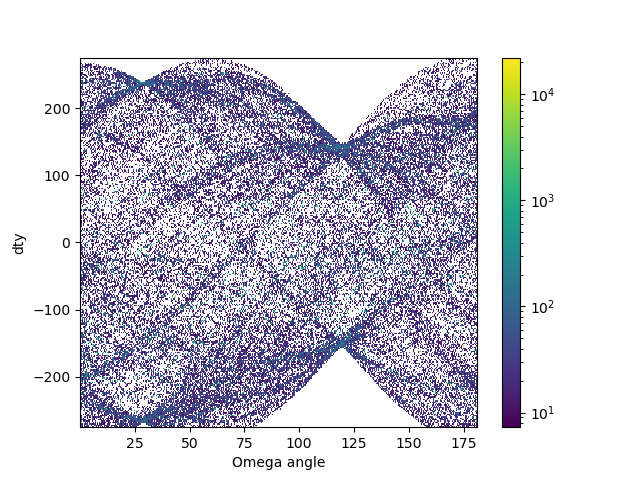

In [14]:
# Generate a mask that selects only 4D peaks greater than 25 pixels in size

m = cf_4d['Number_of_pixels'] > 25

# then plot omega vs dty for all peaks - should look sinusoidal

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(cf_4d['omega'][m], cf_4d['dty'][m], weights=np.sqrt(cf_4d['sum_intensity'][m]), bins=(ds.obinedges, ds.ybinedges), norm=matplotlib.colors.LogNorm())
ax.set_xlabel("Omega angle")
ax.set_ylabel("dty")

fig.colorbar(im, ax=ax)

plt.show()

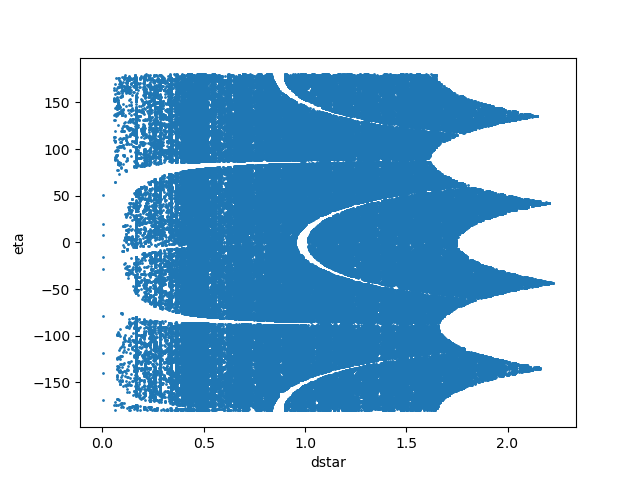

In [15]:
# plot the 4D peaks (fewer of them) as a cake (two-theta vs eta)
# if the parameters in the par file are good, these should look like straight lines

fig, ax = plt.subplots()

ax.scatter(cf_4d.ds, cf_4d.eta, s=1)

ax.set_xlabel("dstar")
ax.set_ylabel("eta")

plt.show()

In [ ]:
# OPTIONAL: export CF to an flt so we can play with it with ImageD11_gui
# uncomment the below line

# cf_4d.writefile(f'{sample}_{dataset}_4d_peaks.flt')

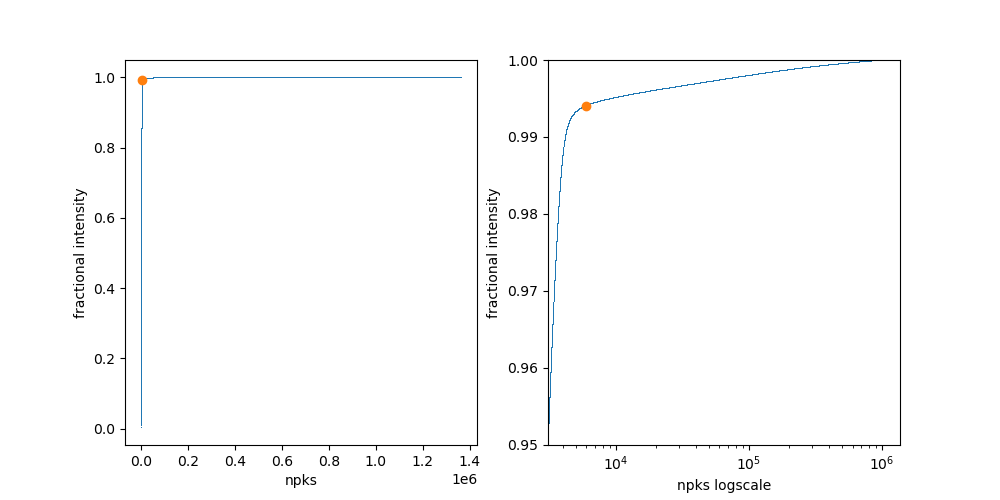

3284422
5946


In [16]:
# here we are filtering our peaks (cf_4d) to select only the strongest ones for indexing purposes only!
# dsmax is being set to limit rings given to the indexer - 6-8 rings is normally good

# USER: modify the "frac" parameter below and re-run the cell until the orange dot sits nicely on the "elbow" of the blue line
# this indicates the fractional intensity cutoff we will select
# if the blue line does not look elbow-shaped in the logscale plot, try changing the "doplot" parameter (the y scale of the logscale plot) until it does

cf_strong = utils.selectpeaks(cf_4d, frac=0.994, dsmax=1.4, doplot=0.95)
print(cf_4d.nrows)
print(cf_strong.nrows)

In [ ]:
# OPTIONAL: export CF to an flt so we can play with it with ImageD11_gui
# uncomment the below line

# cf_strong.writefile(f'{sample}_{dataset}_strong_4d_peaks.flt')

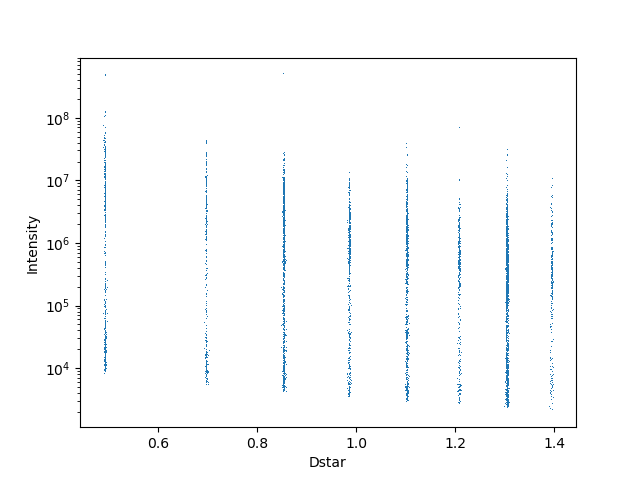

In [17]:
# now we can take a look at the intensities of the remaining peaks

fig, ax = plt.subplots()

ax.plot(cf_strong.ds, cf_strong.sum_intensity,',')
ax.semilogy()

ax.set_xlabel("Dstar")
ax.set_ylabel("Intensity")

plt.show()

In [18]:
# now we can define a unit cell from our parameters

Fe = ImageD11.unitcell.unitcell_from_parameters(cf_strong.parameters)
Fe.makerings(cf_strong.ds.max())

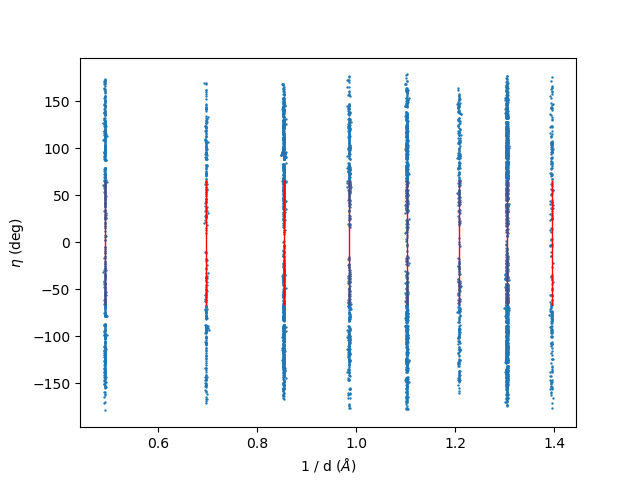

In [22]:
# now let's plot our peaks again, with the rings from the unitcell included, to check our lattice parameters are good

fig, ax = plt.subplots()

skip=1
ax.scatter( cf_strong.ds[::skip], cf_strong.eta[::skip], s=0.5)
ax.plot( Fe.ringds, [0,]*len(Fe.ringds), '|', ms=90, c="red")
ax.set_xlabel('1 / d ($\AA$)')
ax.set_ylabel('$\\eta$ (deg)')

plt.show()

In [ ]:
# specify our ImageD11 indexer with these peaks
# we're aiming to index around 3_000 to 10_000 peaks

indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

print(f"Indexing {cf_strong.nrows} peaks")

In [ ]:
# USER: set a tolerance in d-space (for assigning peaks to powder rings)

indexer.ds_tol = 0.01

# change the log level so we can see what the ring assigments look like

ImageD11.indexing.loglevel = 1

# assign peaks to powder rings

indexer.assigntorings()

# change log level back again

ImageD11.indexing.loglevel = 3

In [ ]:
# let's plot the assigned peaks

fig, ax = plt.subplots()

# indexer.ra is the ring assignments

ax.scatter(cf_strong.ds, cf_strong.eta, c=indexer.ra, cmap='tab20', s=1)
ax.set_xlabel("d-star")
ax.set_ylabel("eta")

plt.show()

In [ ]:
# now we are indexing!
# indexing will select all rings with a multiplicity below max_multiplity to search
max_multiplicity = 11
# the minimum number of peaks on a ring for a ring to be indexed on
min_counts_on_ring = 0
# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9, 0.8, 0.7, 0.6, 0.5]
# the tolerance in g-vector angle
cosine_tol = np.cos(np.radians(90.25))
# the max number of UBIs we can find per pair of rings
max_grains = 1000

grains, indexer = utils.do_index(cf=cf_strong,
                                dstol=indexer.ds_tol,
                                max_mult=max_multiplicity,
                                min_ring_count=min_counts_on_ring,
                                hkl_tols=hkl_tols_seq,
                                fracs=fracs,
                                cosine_tol=cosine_tol,
                                max_grains=max_grains
)

In [ ]:
# set grain GIDs (useful if we ever delete a grain)
for i, g in enumerate(grains):
    g.gid = i
    
    g.a = np.cbrt(np.linalg.det(g.ubi))

In [ ]:
mean_unit_cell_lengths = [grain.a for grain in grains]

fig, ax = plt.subplots()
ax.plot(mean_unit_cell_lengths)
ax.set_xlabel("Grain ID")
ax.set_ylabel("Unit cell length")
plt.show()

a0 = np.median(mean_unit_cell_lengths)
    
print(a0)

In [ ]:
# assign peaks to grains

tol = 0.05

utils.assign_peaks_to_grains(grains, cf_strong, tol=tol)

print("Storing peak data in grains")
# iterate through all the grains
for g in tqdm(grains):
    # store this grain's peak indices so we know which 4D peaks we used for indexing
    g.mask_4d = cf_strong.grain_id == g.gid
    g.peaks_4d = cf_strong.index[cf_strong.grain_id == g.gid]

In [ ]:
utils.plot_index_results(indexer, cf_strong, 'First attempt')

In [ ]:
utils.plot_grain_sinograms(grains, cf_strong)

In [ ]:
# save grain data

save_grains(grains, ds)

In [ ]:
if 1:
    raise ValueError("Change the 1 above to 0 to allow 'Run all cells' in the notebook")

In [ ]:
# Now that we're happy with our segmentation parameters, we can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(rawdata_path, skips_dict, dset_prefix, sample_list)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_200um"]}
    
# now we have our samples_dict, we can process our data:

par_path = os.path.join(processed_data_root_dir, 'Fe_refined.par')

e2dx_path = os.path.join(processed_data_root_dir, '../../CeO2/e2dx_E-08-0173_20231127.edf')
e2dy_path = os.path.join(processed_data_root_dir, '../../CeO2/e2dy_E-08-0173_20231127.edf')

cf_strong_frac = 0.994
cf_strong_dsmax = 1.4
cf_strong_dstol = 0.01

indexer_ds_tol = 0.01
max_multiplicity = 11
min_counts_on_ring = 0
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1]
fracs = [0.9, 0.8, 0.7, 0.6, 0.5]
cosine_tol = np.cos(np.radians(90.25))
max_grains = 1000

peak_assign_tol = 0.05

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        if os.path.exists(ds.grainsfile):
            print(f"Already have grains for {dataset} in sample {sample}, skipping")
            continue
        
        peaks_table = ImageD11.sinograms.properties.pks_table.load(ds.pksfile)
        peaks_2d = peaks_table.pk2d(ds.omega, ds.dty)
        cf_2d = utils.tocolf(peaks_2d, par_path, e2dx_path, e2dy_path)
        if os.path.exists(ds.col2dfile):
            os.remove(ds.col2dfile)
        ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)

        peaks_4d = peaks_table.pk2dmerge(ds.omega, ds.dty)
        cf_4d = utils.tocolf(peaks_4d, par_path, e2dx_path, e2dy_path)  # spatial correction
        index_column = np.arange(cf_4d.nrows)
        cf_4d.addcolumn(index_column, 'index')
        if os.path.exists(ds.col4dfile):
            os.remove(ds.col4dfile)
        ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)
        
        cf_strong = utils.selectpeaks(cf_4d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol)
        


        grains, indexer = utils.do_index(cf=cf_strong,
                                        dstol=indexer_ds_tol,
                                        max_mult=max_multiplicity,
                                        min_ring_count=min_counts_on_ring,
                                        hkl_tols=hkl_tols_seq,
                                        fracs=fracs,
                                        cosine_tol=cosine_tol,
                                        max_grains=max_grains
        )
        
        for i, g in enumerate(grains):
            g.gid = i
            
        utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

        print("Storing peak data in grains")
        for g in tqdm(grains):
            g.mask_4d = cf_strong.grain_id == g.gid
            g.peaks_4d = cf_strong.index[cf_strong.grain_id == g.gid]
            
        save_grains(grains, ds)

print("Done!")